## Center_of_mass_atlas (python 3.6+)
The purpose of this notebook is to explore center of mass calculations for ids (a.k.a "segments") in an annotation atlas. The application is for aligning brains in their raw space by shifting them so that the center of mass of an atlas region is aligned. The procedure for this is as follows (where the bolded step is the one we are testing out in this notebook):
1. Each raw space brain gets a raw space atlas by back-transforming the atlas using the registration transformation parameters. 
2. One brain is chosen as the reference brain
3. **For each brain (including reference brain), calculate the center of mass of a region on which you want to align the brains**
4. Calculate the offset (dx,dy,dz) between the center of mass of this region between each brain and the reference brain.
5. Apply the offset to each of the brains to align them to the reference brain. 

After step 5, all brains can be compared in the same coordinate system (near the region of interest)

In [1]:
import cloudvolume
import numpy as np
import time
import tifffile
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

# Scipy implementation

## Figure out on simple 2D array first

In [2]:
b = np.array(([0,1,1,0],
              [0,1,1,0],
              [0,3,0,0],
              [0,0,2,2],
              [0,0,2,2]))

In [3]:
# Calculate the x,y center of mass for ids 1,2 and 3 
ndimage.measurements.center_of_mass(b,b,index=[1,2,3]) # returns a list of tuples (x,y) for each index (aka id)

[(0.5, 1.5), (3.5, 2.5), (2.0, 1.0)]

## Figure out in atlas space first
Eventually, I will want to determine center of mass of each segment in the volume in the raw data space, but that will be more computationally intensive, so let's try it first in lower resolution atlas space

In [4]:
# Use the 16-bit 2017 allen atlas
atlas_file = '/jukebox/LightSheetTransfer/atlas/allen_atlas/annotation_2017_25um_sagittal_forDVscans_16bit.tif'
data = tifffile.imread(atlas_file)
segments = np.unique(data)

In [5]:
segments[0:10]

array([ 0,  1,  2,  6,  7,  9, 10, 12, 15, 17], dtype=uint16)

In [6]:
# Let's try it out for an index I know is in the list of segments
ndimage.measurements.center_of_mass(data,data,index=[10])

[(227.71669338815713, 359.67279854553266, 87.14533166611689)]

## Now compare to structure_centers.csv

In [7]:
# see: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_centers.csv
centers_file = '/home/ahoag/ngdemo/graphviz/structure_centers.csv'
df = pd.read_csv(centers_file)

In [8]:
df[df['structure_id']==10]

,structure_id,x,y,z,reference_space_id
164,10,8990,2170,4640,10
1004,10,8990,2170,6760,9


It looks like the x,y,z bounds of this file are too large so it's not the same atlas as what we have.

So it looks like we will have to calculate the centers of mass ourselves. Unfortunately this is quite slow, even in just the registered space (which is much larger). 

In [9]:
t1 = time.perf_counter()
centers=ndimage.measurements.center_of_mass(data,data,index=[segments[10:20]])
print(centers)
t2 = time.perf_counter()
print(f'Time elapsed: {t2-t1} seconds')

[(array([227.68534808, 193.34016084, 116.80082935]),), (array([227.63349642, 359.16802791, 194.92039142]),), (array([227.75691899, 229.25385442, 261.16855175]),), (array([227.69747526, 373.68714616,  98.09518455]),), (array([227.88244621, 309.02332956, 148.38346546]),), (array([227.93587873, 362.64426542, 181.08982339]),), (array([227.55374491, 240.4747728 , 256.06612347]),), (array([227.73436472, 357.54001492,  61.08353927]),), (array([227.74616123, 364.11756238, 151.76631478]),), (array([228.63179218, 178.50667302, 180.98204639]),)]
Time elapsed: 4.427063825000005 seconds


OK so ~5 seconds per 10 segments means ~300 seconds or 5 minutes for 600 segments
This is in atlas space though, so we need an idea of how long it will take in raw space

## Raw data space annotation volume

In [10]:
# Just pick one as an example
atlas_file_rawspace = '/jukebox/scratch/kellyms/m61467_demons_dorsal/transformed_annotations/result.tif'

In [11]:
data_rawspace = tifffile.imread(atlas_file_rawspace)

In [12]:
segments_rawspace = np.unique(data_rawspace)

In [13]:
# There are some differences due to bit conversion during transformix. Does not really matter for this example
set(segments_rawspace).difference(set(segments))

{-31360,
 -27456,
 -24000,
 -21792,
 -21760,
 -21728,
 -20768,
 -20736,
 -20704,
 -20672,
 -15456,
 -15440,
 -13376,
 -11264,
 1216,
 2656,
 12096,
 12160,
 12288,
 14144,
 22720,
 28800,
 28864}

In [14]:
# Let's find some that look like reasonable IDs (i.e. non-negative and not very large)
segments_rawspace[100:110] # These should work

array([164, 169, 171, 173, 177, 178, 180, 181, 186, 187], dtype=int16)

In [15]:
segments_rawspace[100:101]

array([164], dtype=int16)

In [16]:
# Now time how long the look-up is in the raw space for a single ID
t1 = time.perf_counter()
centers=ndimage.measurements.center_of_mass(data_rawspace,data_rawspace,index=[segments_rawspace[100]])
print(centers)
t2 = time.perf_counter()
print(f'Time elapsed: {t2-t1} seconds')

[(304.258064516129, 606.5591397849462, 274.81720430107526)]
Time elapsed: 35.12924385699989 seconds


That's wayyy too long for a single ID. We have ~600 IDs Let's try to implement our own function and see if it is faster

# Custom implementation using Numpy 

In [17]:
def calc_center_of_mass2D(a,label):
    """
    ---PURPOSE---
    Calculate center of mass of a label (aka "id" or "segment")
    in a 2D numpy array 
    ---INPUT---
    a        2D numpy array
    label    An integer id that is in the array
    ---OUTPUT--
    y_avg    Average y coordinate of the label in the array
    x_avg    Average x coordinate of the label in the array
             It returns them in this order (y, then x) to conform with scipy's center of mass fn
    """
    y_indices,x_indices = np.where(a==label)
    y_avg = np.mean(y_indices)
    x_avg = np.mean(x_indices)
    return y_avg,x_avg

## Simple 2D case first

In [18]:
b = np.array(([0,1,1,0],
              [0,1,1,0],
              [0,3,0,0],
              [0,0,2,2],
              [0,0,2,2]))

In [19]:
calc_center_of_mass2D(b,1)

(0.5, 1.5)

## Now 3D case

In [20]:
def calc_center_of_mass3D(label,a):
    """
    ---PURPOSE---
    Calculate center of mass of a label (aka "id" or "segment")
    in a 3D numpy array. Order of inputs now switched for when I try to parallelize below.
    ---INPUT---
    a        3D numpy array
    label    An integer id that is in the array
    ---OUTPUT--
    z_avg    Average z coordinate of the label in the array
    y_avg    Average y coordinate of the label in the array
    x_avg    Average x coordinate of the label in the array
             It returns them in this order (z,y,x) to conform with output of scipy's center of mass fn
    """
    z_indices,y_indices,x_indices = np.where(a==label)
    z_avg,y_avg,x_avg = np.mean((z_indices,y_indices,x_indices),axis=1)
    return z_avg,y_avg,x_avg

In [21]:
%%time
calc_center_of_mass3D(label=6,a=data)

CPU times: user 176 ms, sys: 28 ms, total: 204 ms
Wall time: 204 ms


(227.6862375898665, 266.20558028072577, 186.71175743863776)

In [22]:
%%time
# Compare to scipy function
ndimage.measurements.center_of_mass(data,data,index=[6])

CPU times: user 2.88 s, sys: 1.5 s, total: 4.38 s
Wall time: 4.38 s


[(227.6862375898665, 266.20558028072577, 186.71175743863776)]

Custom Numpy implementation is ~20 times faster than scipy's recipe

## Now parallelize
The look-up of center of mass is easily parallelizable because we will be looping through individual IDs and accessing the same, unchanged numpy array

In [23]:
from multiprocessing import Pool #  Process pool
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [24]:
# Time how long 5 take in series (no parallelization) on raw-space annotation atlas
t1 = time.perf_counter()
all_coords = []
for label in segments_rawspace[100:105]:
    coords = calc_center_of_mass3D(a=data_rawspace,label=label)
    all_coords.append(coords)
t2 = time.perf_counter()
print(f"Took {t2-t1} seconds")

Took 2.0019356590000825 seconds


In [25]:
# Time how long 5 take in parallel
t1 = time.perf_counter()
partial_func = partial(calc_center_of_mass3D,a=data_rawspace) # makes a new function with the numpy array fixed (needed for map() below)
with Pool(processes=5) as p:
    results = p.map(partial_func, segments_rawspace[100:105])
t2 = time.perf_counter()
print(f"Took {t2-t1} seconds")

Took 5.075326902000143 seconds


So this is actually slower than in series! First, let's make sure it worked properly

In [26]:
# Check that the centers of mass are the same in series and parallel
results == all_coords

True

It gave the same result, so it's not an obvious bug. Maybe because the array is shared between all parallel processes, that is slowing things down?

Let's try a slightly differently designed center of mass function.

In [27]:
def calc_center_of_mass3D_parallel(label):
    """
    ---PURPOSE---
    Calculate center of mass of a label (aka "id" or "segment")
    in a 3D numpy array. The numpy array "data_rawspace" must be defined globally.
    ---INPUT---
    label    An integer id that is in the array
    ---OUTPUT--
    z_avg    Average z coordinate of the label in the array
    y_avg    Average y coordinate of the label in the array
    x_avg    Average x coordinate of the label in the array
             It returns them in this order (z,y,x) to conform with output of scipy's center of mass fn
    """
    z_indices,y_indices,x_indices = np.where(data_rawspace==label)
    z_avg,y_avg,x_avg = np.mean((z_indices,y_indices,x_indices),axis=1)
    return z_avg,y_avg,x_avg

In [28]:
# Time how long 5 take in parallel for same ids as before, but using new function
t1 = time.perf_counter()
labels = segments_rawspace[100:105]
with Pool(processes=5) as p:
    results = p.map(calc_center_of_mass3D_parallel,labels)
t2 = time.perf_counter()
print(f"Took {t2-t1} seconds")

Took 0.777182301999801 seconds


This is much faster than before, and importantly much faster than the series implementation.

How dependent is the time on the number of parallel processes

In [29]:
processes_list = list(range(1,15))
labels = segments_rawspace[100:110]
durations = []
for n_processes in processes_list:
    t1 = time.perf_counter()
    with Pool(processes=n_processes) as p:
        results = p.map(calc_center_of_mass3D_parallel,labels)
    t2 = time.perf_counter()
    durations.append(t2-t1)

Text(0.5, 1.0, 'Execution time versus number of cores used\nfor 10 center of mass lookups\nin raw-space annotation volume')

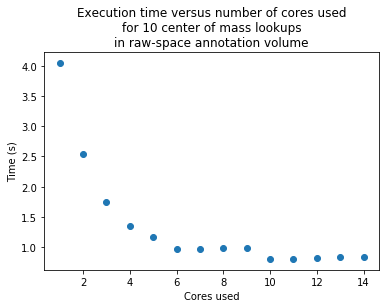

In [30]:
plt.scatter(processes_list,durations)
plt.xlabel('Cores used')
plt.ylabel('Time (s)')
plt.title('Execution time versus number of cores used\nfor 10 center of mass lookups\nin raw-space annotation volume')

There is a minimum around 10 for the desktop linux machines which have 12 cores. 10 is the case where each calculation is getting its own core. More cores is less efficient because of the overhead of launching new parallel processes. 

For a larger set of labels than 10, we will probably want to adopt a slightly different strategy. Also if our cpu architecture changes we will want to adopt a different strategy. 